In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
from google.colab import files
import gzip


def lhe_to_dataframe(lhe_filename):

  # =============================================================
  # Leitor de arquivos .lhe e conversor para pandas.DataFrame
  # =============================================================
  # -------------------------------------------------------------
  # 1. Ler arquivo .lhe usando XML parser
  # -------------------------------------------------------------
  with gzip.open(lhe_filename, "rt") as f:
      content = f.read()

  # Arquivos LHE podem ter headers antes do XML, então ajustamos:
  content = content[content.find("<LesHouchesEvents"):]
  root = ET.fromstring(content)

  # -------------------------------------------------------------
  # 2. Extrair eventos
  # -------------------------------------------------------------
  events_data = []
  event_id = 0
  for event in root.findall("event"):

      event_id += 1  # cada <event> é um novo evento

      lines = event.text.strip().split("\n")

      # Primeira linha contém metadados do evento
      header = lines[0].split()
      n_particles = int(header[0])  # número de partículas

      # Linhas seguintes = partículas
      particle_lines = lines[1 : 1 + n_particles]

      for p in particle_lines:
          vals = p.split()

          # Formato padrão LHE possui 13 colunas:
          # 0: ID, 1: status, 2: mother1, 3: mother2,
          # 4: color1, 5: color2,
          # 6-8: px, py, pz,
          # 9: E, 10: mass,
          # 11: lifetime, 12: spin

          particle_dict = {
              "event_id":   event_id,
              "pdg_id":     int(vals[0]),
              "status":     int(vals[1]),
              "mother1":    int(vals[2]),
              "mother2":    int(vals[3]),
              "color1":     int(vals[4]),
              "color2":     int(vals[5]),
              "px":         float(vals[6]),
              "py":         float(vals[7]),
              "pz":         float(vals[8]),
              "E":          float(vals[9]),
              "mass":       float(vals[10]),
              "lifetime":   float(vals[11]),
              "spin":       float(vals[12]),
          }

          events_data.append(particle_dict)

  # -------------------------------------------------------------
  # 3. Transformar em DataFrame
  # -------------------------------------------------------------
  df = pd.DataFrame(events_data)

  print("DataFrame carregado com sucesso!")
  return df


In [2]:
!git clone https://github.com/FIS01214/lucas-lucas

# -------------------------------------------------------------
# Carregar arquivos .lhe do computador
# -------------------------------------------------------------

sinal_lhe_filename = "/content/lucas-lucas/data/sinal.lhe.gz"
fundo_lhe_filename = "/content/lucas-lucas/data/fundo.lhe.gz"


sinal_df=lhe_to_dataframe(sinal_lhe_filename)

fundo_df = lhe_to_dataframe(fundo_lhe_filename)

#


# # -------------------------------------------------------------
# #Salvar se quiser exportar
# # -------------------------------------------------------------
# # df.to_csv("lhe_to_dataframe.csv", index=False)
# # print("\nArquivo 'lhe_to_dataframe.csv' gerado!")
# # files.download("lhe_to_dataframe.csv")


Cloning into 'lucas-lucas'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 16 (delta 3), reused 6 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), 2.23 MiB | 12.60 MiB/s, done.
Resolving deltas: 100% (3/3), done.
DataFrame carregado com sucesso!
DataFrame carregado com sucesso!


In [3]:
#Número de Eventos(abri o arquivo .lhe e verifiquei na mão que é 10000)
print("Número de eventos do sinal: ", sinal_df['event_id'].nunique())
print("Número de eventos do fundo: ", fundo_df['event_id'].nunique())

Número de eventos do sinal:  10000
Número de eventos do fundo:  10000


In [4]:
# ========================================================
# OBJETIVO 1: Tabela das partículas por status
# ========================================================

# Mapeamento básico PDG → nome de partícula

pdg_names = {
    1: "d", -1: "d̄",
    2: "u", -2: "ū",
    3: "s", -3: "s̄",
    4: "c", -4: "c̄",
    5: "b", -5: "b̄",
    6: "t", -6: "t̄",
    11: "e⁻", -11: "e⁺",
    12: "ν_e", -12: "ν̄_e",
    13: "μ⁻", -13: "μ⁺",
    14: "ν_μ", -14: "ν̄_μ",
    15: "τ⁻", -15: "τ⁺",
    16: "ν_τ", -16: "ν̄_τ",
    21: "g",
    22: "γ",
    23: "Z",
    24: "W⁺", -24: "W⁻",
    25: "H"
}

def name(pdg):
    return pdg_names.get(pdg, str(pdg))

# Adiciona uma coluna com o nome das partículas
sinal_df["particle"] = sinal_df["pdg_id"].apply(name)

fundo_df["particle"] = fundo_df["pdg_id"].apply(name)

# Tabela agrupada por status
tabela_status_sinal = sinal_df.groupby(["status", "particle"]).size().reset_index(name="count")
tabela_status_fundo = fundo_df.groupby(["status", "particle"]).size().reset_index(name="count")

print("=== Tabela de Partículas por Status (Arquivo Sinal) ===")
display(tabela_status_sinal)

print("\n=== Tabela de Partículas por Status (Arquivo Fundo) ===")
display(tabela_status_fundo)



=== Tabela de Partículas por Status (Arquivo Sinal) ===


,status,particle,count
0,-1,c,861
1,-1,c̄,861
2,-1,d,4151
3,-1,d̄,4151
4,-1,s,1374
5,-1,s̄,1374
6,-1,u,3614
7,-1,ū,3614
8,1,e⁺,10000
9,1,e⁻,10000



=== Tabela de Partículas por Status (Arquivo Fundo) ===


,status,particle,count
0,-1,c,1057
1,-1,c̄,1057
2,-1,d,3492
3,-1,d̄,3492
4,-1,s,1140
5,-1,s̄,1140
6,-1,u,4311
7,-1,ū,4311
8,1,e⁺,10000
9,1,e⁻,10000


Processo de sinal: qq̅ ⟶ Z ⟶ e^+ e^-

Processo de fundo: qq̅ ⟶ γ ⟶ e^+ e^-

Eventos únicos representados (sinal): 10000
Eventos únicos representados (fundo):  10000
Partículas finais usadas (sinal): 20000
Partículas finais usadas (fundo):  20000


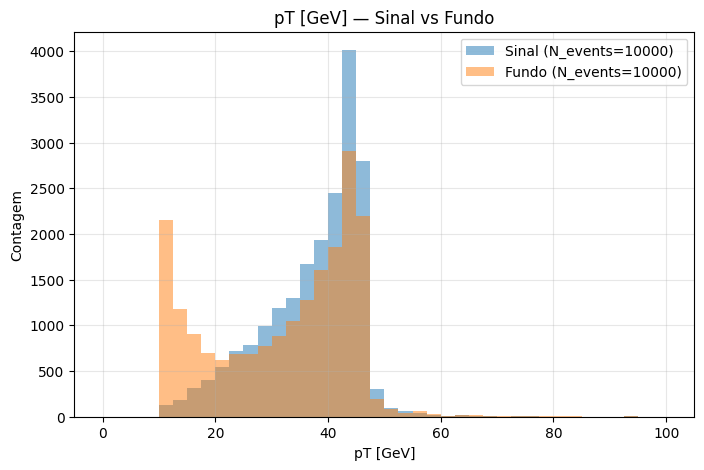

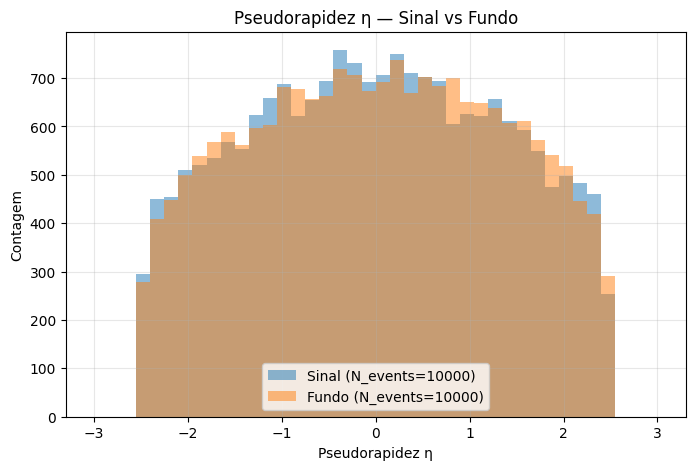

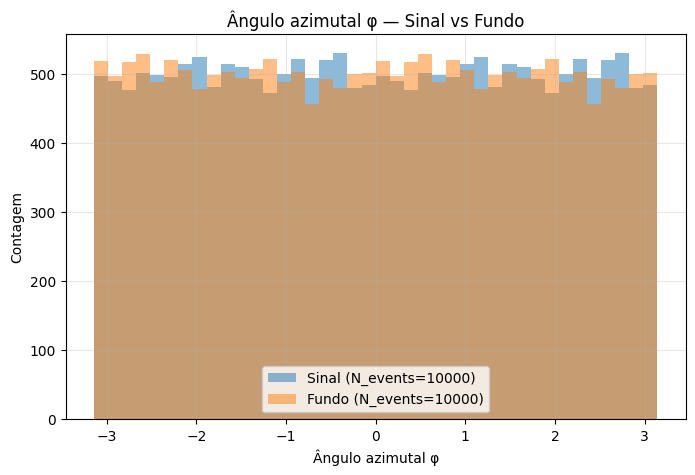

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# --- Checagens / cópias (não alterar os originais) ---
sinal = sinal_df.copy()
fundo = fundo_df.copy()

# --- Calcular pt, eta, phi se não existirem ---
def ensure_kinematics(df):
    # exige px, py, pz (criado no parser LHE)
    if "px" not in df.columns or "py" not in df.columns or "pz" not in df.columns:
        raise ValueError("DataFrame precisa das colunas 'px','py','pz' para calcular cinemática.")

    if "pt" not in df.columns:
        df["pt"] = np.sqrt(df["px"]**2 + df["py"]**2)
    if "phi" not in df.columns:
        df["phi"] = np.arctan2(df["py"], df["px"])  # já em [-pi, pi]
    if "eta" not in df.columns:
        # eta = asinh(pz / pt) is numerically stable for pt>0
        # for pt == 0, set to +/- inf depending on sign(pz)
        pt = df["pt"].values
        pz = df["pz"].values
        eta = np.empty(len(df))
        with np.errstate(divide='ignore', invalid='ignore'):
            # safe for pt>0
            eta = np.arcsinh(pz / pt)
        # where pt==0 set sign(pz)*inf
        zero_mask = (pt == 0)
        if zero_mask.any():
            eta[zero_mask] = np.sign(pz[zero_mask]) * np.inf
        df["eta"] = eta
    return df

sinal = ensure_kinematics(sinal)
fundo = ensure_kinematics(fundo)

# --- Selecionar partículas finais (status = 1) e remover neutrinos ---
neutrinos = {12, 14, 16}
final_sinal = sinal[sinal["status"] == 1].copy()
final_fundo = fundo[fundo["status"] == 1].copy()

# remover neutrinos (baseado em coluna 'pdg_id' ou 'pdg')
pdg_col = None
for c in ("pdg_id", "pdg", "id"):
    if c in final_sinal.columns:
        pdg_col = c
        break
if pdg_col is None:
    raise ValueError("Nenhuma coluna PDG encontrada: aguarda 'pdg_id' ou 'pdg' no DataFrame.")

final_sinal = final_sinal[~final_sinal[pdg_col].abs().isin(neutrinos)]
final_fundo = final_fundo[~final_fundo[pdg_col].abs().isin(neutrinos)]

# --- Remover entradas com eta infinito (caso ocorram) para os histogramas ---
final_sinal = final_sinal.replace([np.inf, -np.inf], np.nan).dropna(subset=["eta"])
final_fundo = final_fundo.replace([np.inf, -np.inf], np.nan).dropna(subset=["eta"])

# --- Número de eventos representados em cada histograma ---
eventos_sinal = final_sinal["event_id"].nunique() if "event_id" in final_sinal.columns else "event_id não encontrado"
eventos_fundo = final_fundo["event_id"].nunique() if "event_id" in final_fundo.columns else "event_id não encontrado"

print(f"Eventos únicos representados (sinal): {eventos_sinal}")
print(f"Eventos únicos representados (fundo):  {eventos_fundo}")
print(f"Partículas finais usadas (sinal): {len(final_sinal)}")
print(f"Partículas finais usadas (fundo):  {len(final_fundo)}")

# --- Função para plotar comparação sinal vs fundo ---
def plot_compare(df_sinal, df_fundo,eventos_sinal, eventos_fundo,var, xlabel, bins, xrng):
    plt.figure(figsize=(8,5))
    # histograma do sinal
    plt.hist(df_sinal[var], bins=bins, range=xrng, alpha=0.5, density=False,
             label=f"Sinal (N_events={eventos_sinal})", histtype="stepfilled")
    # histograma do fundo
    plt.hist(df_fundo[var], bins=bins, range=xrng, alpha=0.5, density=False,
             label=f"Fundo (N_events={eventos_fundo})", histtype="stepfilled")
    plt.xlabel(xlabel)
    plt.ylabel("Contagem")
    plt.title(f"{xlabel} — Sinal vs Fundo")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# --- Histogramas solicitados ---
# pT de 0 a 100 GeV
plot_compare(final_sinal, final_fundo, eventos_sinal, eventos_fundo, "pt", "pT [GeV]", bins=40, xrng=(0,100))

# pseudorapidez η de -3 a +3
plot_compare(final_sinal, final_fundo, eventos_sinal, eventos_fundo,"eta", "Pseudorapidez η", bins=40, xrng=(-3,3))

# ângulo azimutal φ de -π a +π
plot_compare(final_sinal, final_fundo, eventos_sinal, eventos_fundo,"phi", "Ângulo azimutal φ", bins=40, xrng=(-np.pi, np.pi))


In [6]:
'''
Sim, todos os eventos do arquivo .lhe estão representados nos histogramas. A instrução era retirar os eventos nos quais o neutrino
é a partícula final, como se mostrou na tabela de status por partícula, nesses dados não há neutrino,então nenhum evento foi descartado.
'''

'\nSim, todos os eventos do arquivo .lhe estão representados nos histogramas. A instrução era retirar os eventos nos quais o neutrino\né a partícula final, como se mostrou na tabela de status por partícula, nesses dados não há neutrino,então nenhum evento foi descartado.\n'

=== Corte 23 < pT < 50 GeV ===
Sinal: 18000 partículas finais selecionadas
Fundo: 13944 partículas finais selecionadas
Eventos únicos (sinal): 9000
Eventos únicos (fundo): 6972


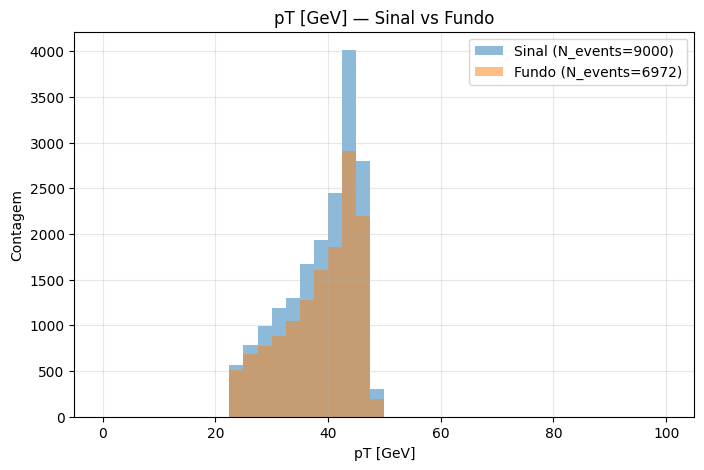

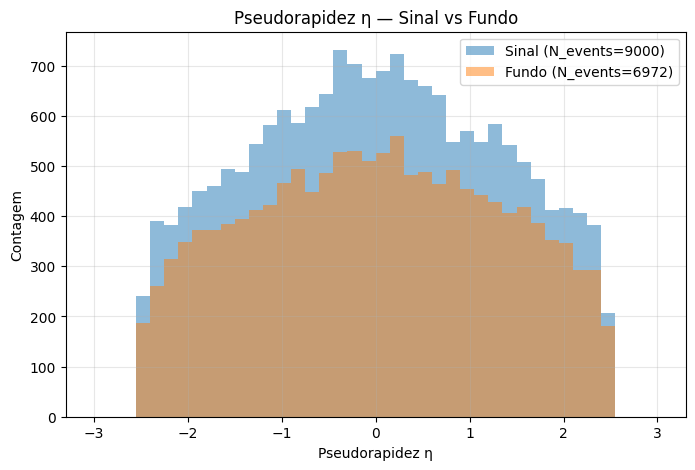

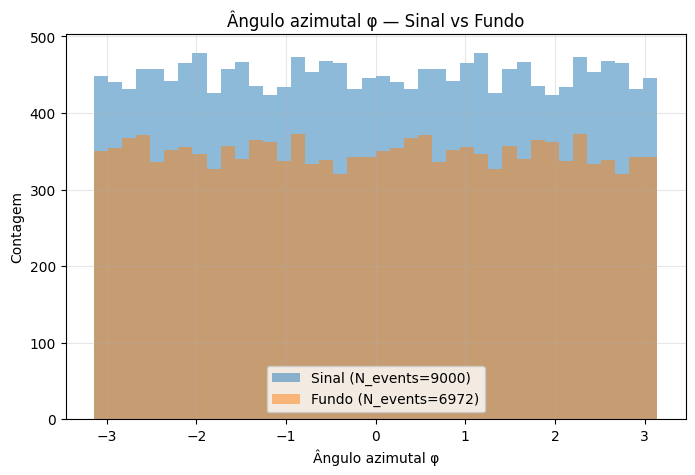

In [7]:
# -----------------------------------------
# FILTRAGEM para 23 < pT < 55 GeV -> Pelo histograma geral dá pra ver que é a região onde sinal>fundo
# -----------------------------------------

pt_min = 23
pt_max = 50

final_sinal_pt_window = final_sinal[(final_sinal["pt"] > pt_min) &
                                    (final_sinal["pt"] < pt_max)].copy()

final_fundo_pt_window = final_fundo[(final_fundo["pt"] > pt_min) &
                                    (final_fundo["pt"] < pt_max)].copy()

# Contagem de eventos únicos
eventos_sinal_window = final_sinal_pt_window["event_id"].nunique()
eventos_fundo_window = final_fundo_pt_window["event_id"].nunique()

print(f"=== Corte {pt_min} < pT < {pt_max} GeV ===")
print(f"Sinal: {len(final_sinal_pt_window)} partículas finais selecionadas")
print(f"Fundo: {len(final_fundo_pt_window)} partículas finais selecionadas")
print(f"Eventos únicos (sinal): {eventos_sinal_window}")
print(f"Eventos únicos (fundo): {eventos_fundo_window}")

# --- Histogramas solicitados ---
# pT de 0 a 100 GeV
plot_compare(final_sinal_pt_window, final_fundo_pt_window, eventos_sinal_window, eventos_fundo_window, "pt", "pT [GeV]", bins=40, xrng=(0,100))

# pseudorapidez η de -3 a +3
plot_compare(final_sinal_pt_window, final_fundo_pt_window, eventos_sinal_window, eventos_fundo_window, "eta", "Pseudorapidez η", bins=40, xrng=(-3,3))

# ângulo azimutal φ de -π a +π
plot_compare(final_sinal_pt_window, final_fundo_pt_window, eventos_sinal_window, eventos_fundo_window, "phi", "Ângulo azimutal φ", bins=40, xrng=(-np.pi, np.pi))


